In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import torch
import torch.nn as nn
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.transforms import CenterCrop
import numpy as np
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize
from pathlib import Path
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Модель

In [3]:
class ConvReLU(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class EncoderBlockUnet(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=[1,1,]) -> None:
        super(EncoderBlockUnet, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding[i]))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x_copy = x
        x = self.pool(x)
        return x, x_copy

class DecoderBlockUnet(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=[1,1,]) -> None:
        super(DecoderBlockUnet, self).__init__()
        self.unconv = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == 0:
                self.layers.append(ConvReLU(in_c, out_c, kernel_size=kernel_size, padding=padding[i]))
            else:
                self.layers.append(ConvReLU(out_c, out_c, kernel_size=kernel_size, padding=padding[i]))

    def forward(self, x, x_copy):
        x = self.unconv(x)
        (_, _, H, W) = x.shape
        x_crop = CenterCrop(size=[H, W])(x_copy)
        x = torch.cat((x, x_crop), dim=1)
        for layer in self.layers:
            x = layer(x)
        return x

class UNet(nn.Module):
    def __init__(self, input_img_size = 326, n_class=1):
        super().__init__()
        self.input_img_size = input_img_size
        # encoder
        self.encoder1 = EncoderBlockUnet(3, 64, padding=[0, 1])
        self.encoder2 = EncoderBlockUnet(64, 64*2, padding=[0, 1])
        self.encoder3 = EncoderBlockUnet(64*2, 64*4)
        self.encoder4 = EncoderBlockUnet(64*4, 64*8)
        # bottleneck
        self.bottleneck = nn.Sequential(
            ConvReLU(64*8, 64*16, padding=0),
            ConvReLU(64*16, 64*16, padding=0)
        )
        # decoder (upsampling)
        self.decoder1 = DecoderBlockUnet(64*16, 64*8)
        self.decoder2 = DecoderBlockUnet(64*8, 64*4)
        self.decoder3 = DecoderBlockUnet(64*4, 64*2, padding=[1, 0])
        self.decoder4 = DecoderBlockUnet(64*2, 64, padding=[1, 0])
        self.conv_last  = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # encoder
        enc1_in = x
        enc2_in, enc1_out = self.encoder1(enc1_in)
        enc3_in, enc2_out = self.encoder2(enc2_in)
        enc4_in, enc3_out = self.encoder3(enc3_in)
        bottleneck_in, enc4_out = self.encoder4(enc4_in)
        # bottleneck
        bottleneck_out = self.bottleneck(bottleneck_in)
        #decoder
        dec1_out = self.decoder1(bottleneck_out, enc4_out)
        dec2_out = self.decoder2(dec1_out, enc3_out)
        dec3_out = self.decoder3(dec2_out, enc2_out)
        dec4_out = self.decoder4(dec3_out, enc1_out)
        output = self.conv_last(dec4_out)
        return output

## Функции предсказания и обработки изображений

In [4]:
"""
Генератор разбиения изображения на подизображения.

Принимает изображение уже в виде тензора и размеры подизображения.
Возвращает подизображение и его координаты в исходном изображении.
"""
def sub_img_generator(image, sub_img_size):
    for row in range(image.shape[1]//sub_img_size[0]):
        for col in range(image.shape[2]//sub_img_size[1]):
            yield image[:,
                    row * sub_img_size[0]:
                    (row + 1) * sub_img_size[0],
                    col * sub_img_size[1]:
                    (col + 1) * sub_img_size[1]

            ], row * sub_img_size[0],(row + 1) * sub_img_size[0], col * sub_img_size[1],(col + 1) * sub_img_size[1]

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

test_transform = Compose([
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

"""
Функция обработки изображение перед подачей в модель.

Добавляет зеркальные границы к изображению для получения размера 326x326.
"""
def process_image(image):
    (_, H, W) = image.shape
    pad_h = (326 - H) // 2
    pad_w = (326 - W) // 2
    padded_image = F.pad(
        image,
        pad=(pad_w, pad_w, pad_h, pad_h),  # (left, right, top, bottom)
        mode='reflect'
    )
    return padded_image

"""
Предсказание для одного изображения
"""
def predict_one(model, inputs):
    with torch.set_grad_enabled(False):
        inputs = inputs.to(DEVICE)
        outputs = model(inputs).cpu().detach().numpy().squeeze()
        mask = outputs > 0.5
    return mask

"""
Основная функция предсказания площади застройки.

На вход принимает модель, аэрофотоснимок, размерность (м/пиксель).
Преобразует изображение в тензор и нормализует его.
Исходное изображение разбивается на подизображения, для каждого с помощью модели
предсказывается маска застройки и рассчитывается площадь застройки в м².
Возвращается общая площадь и общая маска застройки для исходного изображения.
"""
def make_prediction(model, image, dimension):
    # общая площадь
    all_area = 0
    # размерность в м²/пиксель
    dimension *= dimension
    # общая маска
    mask = np.zeros([image.size[1], image.size[0]])
    image = test_transform(image)
    sub_gen = sub_img_generator(image, (250,250))
    for subimg, row1, row2, col1, col2 in sub_gen:
        img = process_image(subimg)
        submask = predict_one(model, img.unsqueeze(0)).astype(int)
        area = np.count_nonzero(submask)
        all_area += area*dimension
        mask[row1:row2,col1:col2] = submask
    return all_area, mask



# Инференс

Выполним предсказание для размеченного изображения из тренировочного набора датасета Inria, который использовался для обучения модели. Тренировочный датасет содержит по 36 изображений для пяти разных регионов. Т.к. для обучения использовался не весь датасет, а по 10 изображений для каждого региона, данное изображение не участвовало в обучении. Но регион модели известен.

Разрешение изображение в данном датасете 0.3 м/пиксель.

Посчитаем площадь по GT и сравним с предсказанным значением.

In [5]:
image1 = Image.open('/content/gdrive/MyDrive/final project dls/testing/vienna36_img.tif')
gt1 = Image.open('/content/gdrive/MyDrive/final project dls/testing/vienna36_gt.tif')

In [7]:
model = UNet().to(DEVICE)
checkpoints = torch.load(Path('/content/gdrive/MyDrive/final project dls/testing/best_iou.pt'), map_location=DEVICE)
model.load_state_dict(checkpoints['model_state_dict'])
model.eval()

UNet(
  (encoder1): EncoderBlockUnet(
    (layers): ModuleList(
      (0): ConvReLU(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvReLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): EncoderBlockUnet(
    (layers): ModuleList(
      (0): ConvReLU(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvReLU(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [8]:
all_area, mask = make_prediction(model, image1, 0.3)

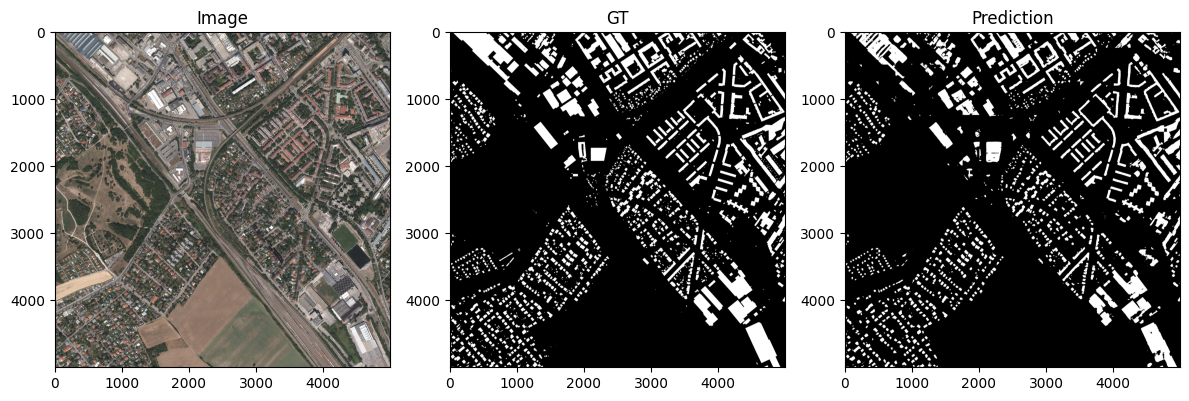

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12, 12))

img = np.array(image1)
gt = np.array(gt1)
ax[0].set_title("Image")
ax[0].imshow(img)
ax[1].set_title("GT")
ax[1].imshow(gt, cmap='gray')
ax[2].set_title("Prediction")
ax[2].imshow(mask, cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
print(f"Площадь GT: {np.count_nonzero(gt)*0.09} м²")
print(f"Площадь предсказанная: {all_area} м²")

Площадь GT: 363584.88 м²
Площадь предсказанная: 315149.4 м²


Визуально предсказанная маска близка к GT. Однако погрешность в значениях площади все же есть и равна 48435 м². Т.е. модель занизила площадь примерно на 13%.



Посмотрим на предсказание для изображение из тестовой выборки Inria.

In [10]:
image_test = Image.open('/content/gdrive/MyDrive/final project dls/testing/bellingham25.tif')

In [11]:
all_area, mask = make_prediction(model, image_test, 0.3)

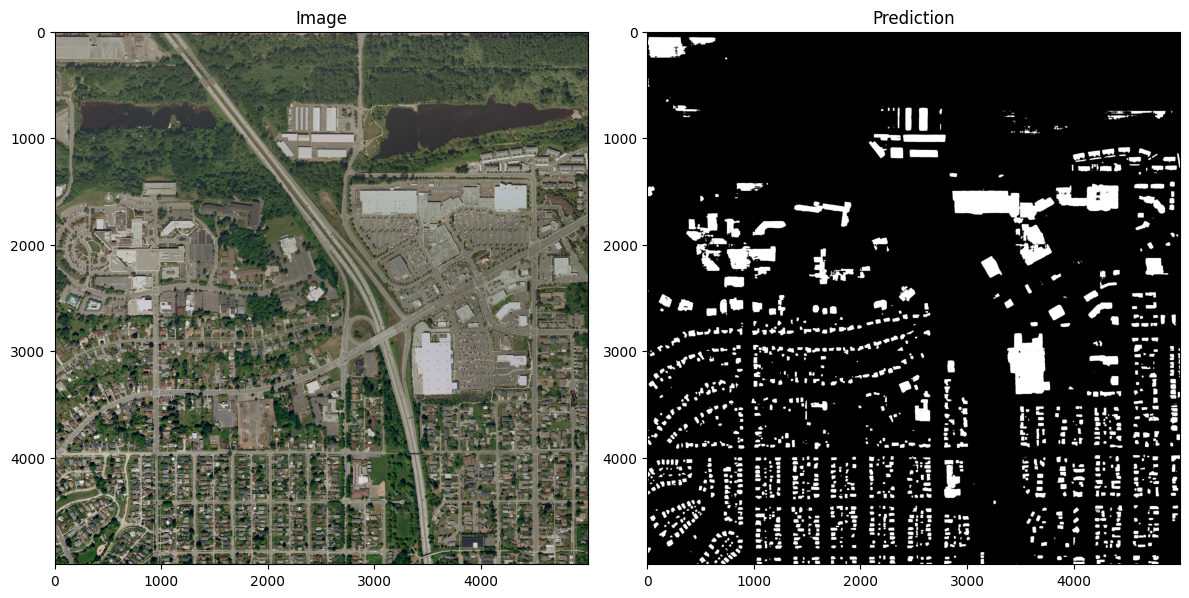

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 12))

img = np.array(image_test)

ax[0].set_title("Image")
ax[0].imshow(img)
ax[1].set_title("Prediction")
ax[1].imshow(mask, cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
print(f"Площадь предсказанная: {all_area:.2f} м²")

Площадь предсказанная: 246030.93 м²


# Выводы:

Метрики на тестовой выборке:

IoU = 0.718109

Dice = 0.821252

Precision = 0.789574

Recall = 0.904220

IoU говорит о том, что модель корректно сегментирует 71% площади зданий. При обучении акцент делался на увеличение метрики Reacall. Т.е. полученная модель не должна пропускать более 10% зданий. Судя по Precision модель может допускать до 21% ложных предсказаний. Предсказанная площадь меньше реальной на 13%, т.е. модель больше пропускает, чем ошибочно добавляет. Скорей всего ложные объекты меньше по площади, чем те, которые пропущены. Также модель хорошо сегментирует здания, но допускает ошибки на границах, а также на сосвем маленьких зданиях и теряет фрагменты больших зданий. Также влияет разрешение избражения. Один пропущенный пиксель равнозначен потери площади на 0.09 м².

В целом, модель достаточно хорошо сегментирует здания и расчитывает площадь. Однако для задач, где требуетя более высокая точность, необходимо ее дообучать. Возможно стоит добавить больше аугментации, попробовать другие значения гипперпараметров, пробовать дргие функции потерь, оптимизатор или изменить архитектуру. Может стоит добавит постобработку масок, чтобы заполнить очевидные пропуски.


